In [ ]:
!pip install fastcore fastai --upgrade
!pip install scikit-surprise

In [ ]:
import torch
from google.colab import drive
from fastai.tabular.all import *
from fastai.collab import *
import surprise
import seaborn as sns;
import math;
import numpy;
from sklearn.metrics.pairwise import cosine_similarity;
import operator;
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
drive.mount('/content/drive');

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/netflix_dataset'

In [ ]:
! ls $path

combined_data_1.txt  combined_data_3.txt  movie_titles.csv  qualifying.txt
combined_data_2.txt  combined_data_4.txt  probe.txt


In [ ]:
ratings_filename_1 = 'combined_data_1.txt'
ratings_filename_2 = 'combined_data_2.txt'
ratings_filename_3 = 'combined_data_3.txt'
ratings_filename_4 = 'combined_data_4.txt'

movies_filename = 'movie_titles.csv'

In [ ]:
df_ratings_1 = pd.read_csv(f'{path}/{ratings_filename_1}', header=None, names=['customer_id', 'rating'], usecols=[0,1])
df_ratings_1['rating'] = df_ratings_1['rating'].astype(float)
df_ratings_1.head()

,customer_id,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [ ]:
# df_ratings_2 = pd.read_csv(f'{path}/{ratings_filename_2}', header=0, names=['customer_id', 'rating'], usecols=[0,1])
# df_ratings_2['rating'] = df_ratings_2['rating'].astype(float)
# df_ratings_2.head()

In [ ]:
# df_ratings_3 = pd.read_csv(f'{path}/{ratings_filename_3}', header=0, names=['customer_id', 'rating'], usecols=[0,1])
# df_ratings_3['rating'] = df_ratings_3['rating'].astype(float)
# df_ratings_3.head()

In [ ]:
# df_ratings_4 = pd.read_csv(f'{path}/{ratings_filename_4}', header=0, names=['customer_id', 'rating'], usecols=[0,1])
# df_ratings_4['rating'] = df_ratings_4['rating'].astype(float)
# df_ratings_4.head()

In [ ]:
df_ratings = df_ratings_1
# df_ratings = df_ratings.append(df_ratings_2)
# df_ratings = df_ratings.append(df_ratings_3)
# df_ratings = df_ratings.append(df_ratings_4)
df_ratings.index = np.arange(0,len(df_ratings))

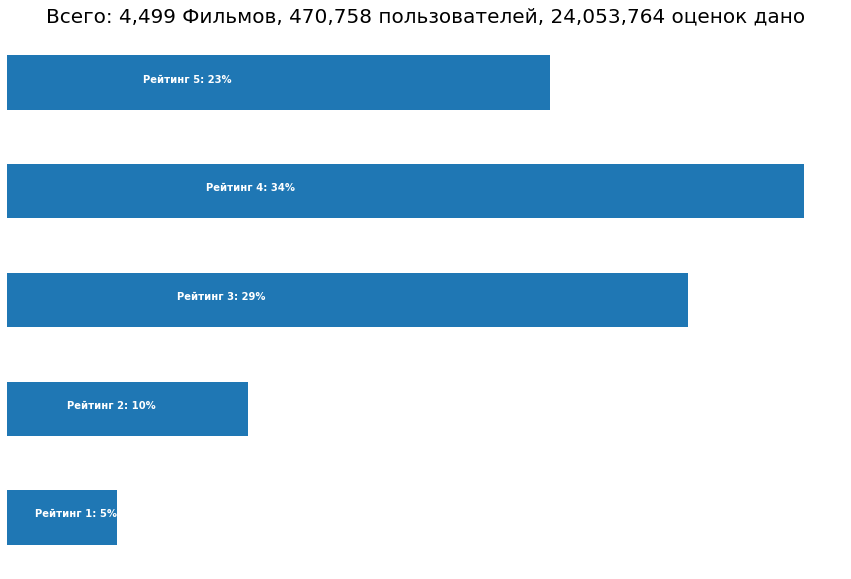

In [ ]:
agg_df_ratings = df_ratings.groupby('rating')['rating'].agg(['count'])
Movie_count = df_ratings.isnull().sum()[1]
Customer_count = df_ratings['customer_id'].nunique() - Movie_count
Rating_count = df_ratings['customer_id'].count() - Movie_count

axs = agg_df_ratings.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Всего: {:,} Фильмов, {:,} пользователей, {:,} оценок дано'.format(Movie_count, Customer_count, Rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    axs.text(agg_df_ratings.iloc[i-1][0]/4, i-1, 'Рейтинг {}: {:.0f}%'.format(i, agg_df_ratings.iloc[i-1][0]*100 / agg_df_ratings.sum()[0]), color = 'white', weight = 'bold')

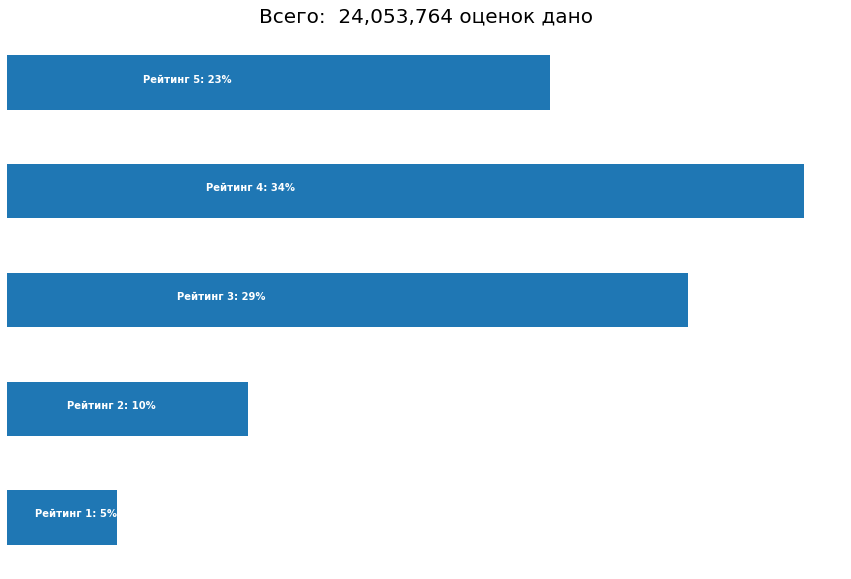

In [ ]:
axs = agg_df_ratings.plot(kind = 'barh', legend = False, 
figsize = (15,10))
plt.title( 'Всего:  {:,} оценок дано'.format(Rating_count), fontsize=20)
plt.axis('off')
for i in range(1,6):  
  s = agg_df_ratings.sum()[0]
  calc_stat = agg_df_ratings.iloc[i-1][0]*100 / s
  text = 'Рейтинг {}: {:.0f}%'.format(i, calc_stat)
  axs.text(agg_df_ratings.iloc[i-1][0]/4, i-1, text, 
  color = 'white', weight = 'bold')


In [ ]:
dataframe_nan = pd.DataFrame(pd.isnull(df_ratings.rating))
dataframe_nan = dataframe_nan[dataframe_nan['rating'] == True]
dataframe_nan = dataframe_nan.reset_index()

movie_numpy_arr = []
movie_id = 1
for i,j in zip(dataframe_nan['index'][1:], dataframe_nan['index'][:-1]):
    t = np.full((1,i-j-1), movie_id)
    movie_numpy_arr = np.append(movie_numpy_arr, t)
    movie_id += 1

l_rec = np.full((1,len(df_ratings) - dataframe_nan.iloc[-1, 0] - 1), movie_id)
movie_np = np.append(movie_numpy_arr, l_rec)

In [ ]:
print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [ ]:
df_ratings = df_ratings[pd.notnull(df_ratings['rating'])]

df_ratings['movie_id'] = movie_np.astype(int).copy()
df_ratings['customer_id'] = df_ratings['customer_id'].astype(int).copy()
print('-Dataset examples-')
print(df_ratings.iloc[::5000000, :])

-Dataset examples-
          customer_id  rating  movie_id
1             1488844     3.0         1
5000996        501954     2.0       996
10001962       404654     5.0      1962
15002876       886608     2.0      2876
20003825      1193835     2.0      3825


In [ ]:
funs = ['count', 'mean']
dataframe_movie_sum = df_ratings.groupby('movie_id')['rating'].agg(funs)
dataframe_movie_sum.index = dataframe_movie_sum.index.map(int)
movie_bench = round(dataframe_movie_sum['count'].quantile(0.7), 0)
drop_movie_list = dataframe_movie_sum[dataframe_movie_sum['count'] 
< movie_bench].index


dataframe_customer_sum = df_ratings.groupby('customer_id')['rating'].agg(funs)
dataframe_customer_sum.index = dataframe_customer_sum.index.map(int)
customer_benchmark = round(dataframe_customer_sum['count'].quantile(0.7), 0)
drop_customer_list = dataframe_customer_sum[dataframe_customer_sum['count'] < customer_benchmark].index

In [ ]:
print('Original Shape: {}'.format(df_ratings.shape))
df_ratings = df_ratings[~df_ratings['movie_id'].isin(drop_movie_list)]
df_ratings = df_ratings[~df_ratings['customer_id'].isin(drop_customer_list)]
print('After Trim Shape: {}'.format(df_ratings.shape))
print('-Data Examples-')
print(df_ratings.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          customer_id  rating  movie_id
696            712664     5.0         3
6932490       1299309     5.0      1384
13860273       400155     3.0      2660
20766530       466962     4.0      3923


In [ ]:
df_title = pd.read_csv(f'{path}/{movies_filename}', encoding = 'ISO-8859-1', names=['movie_id', 'year', 'name'], on_bad_lines='skip')
df_title.set_index('movie_id', inplace=True)


In [ ]:
print(len(df_title))

17770


In [ ]:
df = df_ratings[['customer_id', 'movie_id', 'rating']][:100000]

In [ ]:
gdf = df.groupby('customer_id')
groups_items = gdf.groups.items()
arrs = {}

In [ ]:
# for user, rows in groups_items:
#   print(rows.values)
print(len(groups_items))

74261


In [ ]:
# i = 0
# for user, rows in groups_items:
#   user_ratings = {}
#   for row in rows:
#     key = df.loc[[row]]['movie_id'].values[0]
#     val = df.loc[[row]]['rating'].values[0]
#     user_ratings[key] = val
#   arrs[user] = user_ratings
#   print(i)
#   i+=1

In [ ]:
# file = open("test.pkl", "wb")
# pickle.dump(arrs, file)
# file.close()
# print(arrs)
# file = open("test.pkl", "rb")
# out = pickle.load(file)

In [ ]:
# print(out)

In [ ]:
def generate_np_arr(dict):
  i = 0
  arr = np.zeros(len(df_title), dtype=int)
  for key, value in dict.items():
    arr[int(key)] = int(value)
  return arr

In [ ]:
# example = {8: 3.0, 28: 2.0}
# arr = generate_np_arr(example)

In [ ]:
# print(arr)

In [ ]:
# здесь вычисляю угол между косинусом (cosine similarity)
def calc_max_cos_sim(new_user):
  cos_matrix = {}
  # example = {8: 3.0, 28: 2.0}
  users_ratings = out
  # print(len(users_ratings))
  # example_np = generate_np_arr(example).reshape(1,-1)
  new_user_np = generate_np_arr(new_user).reshape(1,-1)
  # test_np = {7: users_ratings[7], 79: users_ratings[79]}

  for id, ratings in users_ratings.items():
    cur_arr = generate_np_arr(ratings).reshape(1,-1)
    cos_matrix[id] = cosine_similarity(cur_arr, new_user_np)[0][0]
  return max(cos_matrix.items(), key=operator.itemgetter(1))[0]

In [ ]:
reader = surprise.Reader(rating_scale=(1, 5))
data = surprise.Dataset.load_from_df(df_ratings[['customer_id', 'movie_id', 'rating']][:8000000], reader);

In [ ]:
trainset, testset = surprise.model_selection.train_test_split(data, test_size=.2)

In [ ]:
df_ratings = df_ratings[['customer_id', 'movie_id', 'rating']][:8000000]

In [ ]:
reader = surprise.Reader(rating_scale=(1, 5))
data = surprise.Dataset.load_from_df(df_ratings, reader)
trainset, testset = surprise.model_selection.train_test_split(data, test_size=.2)

In [ ]:
model = surprise.dump.load('static/surprise_model')

In [ ]:
svd = surprise.SVD(n_factors = 300, n_epochs=100, lr_all = 0.005, reg_all = 0.02)
svd.fit(trainset)
predictions = svd.test(testset)
surprise.accuracy.rmse(predictions)
# model = surprise.dump.load('drive/MyDrive/surprise_model')
# surprise.model_selection.cross_validate(svd, data, measures=['RMSE', 'MAE'], verbose = True, cv=3)
# surprise.model_selection.cross_validate(svd, data, measures=['RMSE', 'MAE'])

RMSE: 0.8789


0.8789315562145458

In [ ]:
predictions = svd.test(testset)


In [ ]:
surprise.accuracy.rmse(predictions) 

RMSE: 0.8789


0.8789315562145458

In [ ]:
surprise.accuracy.mse(predictions)

MSE: 0.7725


0.7725206805097232

In [ ]:
surprise.accuracy.mae(predictions)

MAE:  0.6860


0.6859896984858853

In [ ]:
surprise.accuracy.mse(predictions)

In [ ]:
surprise.dump.dump('/content/drive/MyDrive/surprise_model_1.pickle', predictions , svd)

In [ ]:
df_user = df_ratings[(df_ratings['customer_id'] == res) & (df_ratings['rating'] == 5)]
df_user = df_user.set_index('movie_id')
df_user = df_user.join(df_title)['name']
print(len(df_user))

14


In [ ]:
titles = df_title.copy()
titles = titles.reset_index()
titles = titles[~titles['movie_id'].isin(drop_movie_list)]

# titles.head()
model = surprise.dump.load('drive/MyDrive/surprise_model')
titles['estimate_score'] = titles['movie_id'].apply(lambda x: model[1].predict(7, x).est)
titles = titles.drop('movie_id', axis = 1)

titles = titles.sort_values('estimate_score', ascending = False)
titles.head(10).to_dict()

In [ ]:
res_arr = []
print(res.year.keys())
for key in res.year.keys():
  movie = {}
  movie['id'] = key
  movie['year'] = res.year[key]
  movie['title'] = res.name[key]
  res_arr.append(movie)
print(res_arr)

Int64Index([7, 67, 174, 151, 43, 27, 55, 32, 190, 137], dtype='int64')
[{'id': 7, 'year': 2004.0, 'title': 'What the #$*! Do We Know!?'}, {'id': 67, 'year': 2004.0, 'title': 'Invader Zim'}, {'id': 174, 'year': 1992.0, 'title': 'Reservoir Dogs'}, {'id': 151, 'year': 1995.0, 'title': 'A Little Princess'}, {'id': 43, 'year': 1996.0, 'title': 'Spitfire Grill'}, {'id': 27, 'year': 2002.0, 'title': 'Lilo and Stitch'}, {'id': 55, 'year': 2004.0, 'title': 'Carandiru'}, {'id': 32, 'year': 2000.0, 'title': 'Aqua Teen Hunger Force: Vol. 1'}, {'id': 190, 'year': 2003.0, 'title': 'X2: X-Men United'}, {'id': 137, 'year': 1995.0, 'title': 'Star Trek: Voyager: Season 1'}]
